In [1]:
%matplotlib widget

import os
import numpy as np
import yaml
from tqdm.notebook import tqdm
import galsim
import batoid
import wfsim
import matplotlib.pyplot as plt

from lsst.ts.wep.cwfs.Algorithm import Algorithm
from lsst.ts.wep.cwfs.CompensableImage import CompensableImage
from lsst.ts.wep.cwfs.Instrument import Instrument
from lsst.ts.wep.Utility import (
    CamType,
    DefocalType,
    getConfigDir,
    getModulePath
)

In [2]:
rng = np.random.default_rng(5772156649015328606065120900824024310421)

In [3]:
bandpass = galsim.Bandpass("LSST_r.dat", wave_type='nm')
fiducial_telescope = batoid.Optic.fromYaml("LSST_r.yaml")
factory = wfsim.SSTFactory(fiducial_telescope)
pixel_scale = 10e-6

In [4]:
# Setup observation parameters.  Making ~plausible stuff up.
observation = {
    'zenith': 30 * galsim.degrees,
    'raw_seeing': 0.7 * galsim.arcsec,  # zenith 500nm seeing
    'wavelength': bandpass.effective_wavelength,
    'exptime': 15.0,  # seconds
    'temperature': 293.,  # Kelvin
    'pressure': 69.,  #kPa
    'H2O_pressure': 1.0  #kPa
}

In [5]:
# Setup atmospheric parameters
atm_kwargs = {
    'screen_size': 819.2,
    'screen_scale': 0.1,
    'nproc': 6  # create screens in parallel using this many CPUs
}

In [6]:
dof = np.zeros(50)
# dof[40:44] = 0.2  # activate some M2 bending modes
dof = rng.normal(scale=0.05, size=50)
# but zero-out the hexafoil modes that aren't currently fit well.
dof[[28, 45, 46]] = 0
telescope = factory.get_telescope(dof=dof)  # no perturbations yet

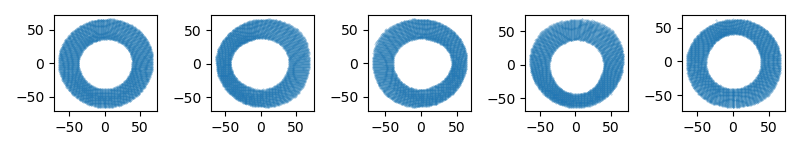

In [7]:
# Look at some spot diagrams
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(8, 1.5))
for ax, (thx, thy) in zip(axes, [(0,0), (-1.5, 0), (1.5, 0), (0, -1.5), (0, 1.5)]):
    sx, sy = batoid.spot(
        telescope.withGloballyShiftedOptic("Detector", [0, 0, 0.0015]), 
        np.deg2rad(thx), np.deg2rad(thy), 
        bandpass.effective_wavelength*1e-9, 
        nx=128
    )
    ax.scatter(sx/pixel_scale, sy/pixel_scale, s=0.1, alpha=0.5)
plt.tight_layout()
plt.show()

In [8]:
intra = telescope.withGloballyShiftedOptic("Detector", [0, 0, -0.0015])
extra = telescope.withGloballyShiftedOptic("Detector", [0, 0, +0.0015])

In [9]:
intra_simulator = wfsim.SimpleSimulator(
    observation,
    atm_kwargs,
    intra,
    bandpass,
    shape=(256, 256),
    rng=rng
)
extra_simulator = wfsim.SimpleSimulator(
    observation,
    atm_kwargs,
    extra,
    bandpass,
    shape=(256, 256),
    rng=rng
)

In [10]:
star_T = rng.uniform(4000, 10000)
sed = wfsim.BBSED(star_T)
# flux = int(rng.uniform(1_000_000, 2_000_000))
flux = 10_000_000

In [11]:
intra_simulator.add_star(0.0, 0.0, sed, flux, rng)
extra_simulator.add_star(0.0, 0.0, sed, flux, rng)

In [12]:
intra_simulator.add_background(1000.0, rng)
extra_simulator.add_background(1000.0, rng)

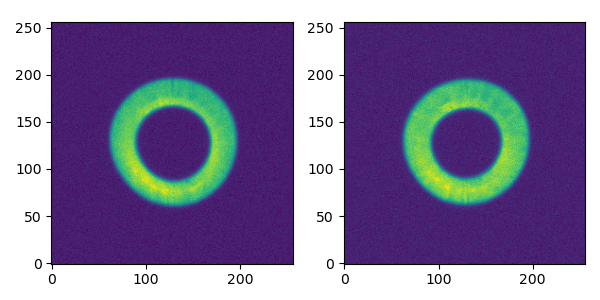

In [13]:
fix, axes = plt.subplots(ncols=2, nrows=1, figsize=(6, 3))
axes[0].imshow(intra_simulator.image.array)
axes[1].imshow(extra_simulator.image.array)
plt.tight_layout()
plt.show()

In [14]:
# CWFS
cwfsConfigDir = os.path.join(getConfigDir(), "cwfs")
instDir = os.path.join(cwfsConfigDir, "instData")
inst = Instrument(instDir)
algoDir = os.path.join(cwfsConfigDir, "algo")

In [15]:
fieldXY = np.zeros(2)
I1 = CompensableImage()
I2 = CompensableImage()
I1.setImg(fieldXY, DefocalType.Intra, image=intra_simulator.image.array.copy())
I2.setImg(fieldXY, DefocalType.Extra, image=extra_simulator.image.array.copy())
inst.config(CamType.LsstFamCam, I1.getImgSizeInPix(), announcedDefocalDisInMm=1.5)

fftAlgo = Algorithm(algoDir)
fftAlgo.config("fft", inst)
fftAlgo.runIt(I1, I2, "offAxis", tol=1e-3)

# There's probably a reset method somewhere, but it's fast enough to just
# reconstruct these...
I1 = CompensableImage()
I2 = CompensableImage()
I1.setImg(fieldXY, DefocalType.Intra, image=intra_simulator.image.array.copy())
I2.setImg(fieldXY, DefocalType.Extra, image=extra_simulator.image.array.copy())
inst.config(CamType.LsstFamCam, I1.getImgSizeInPix(), announcedDefocalDisInMm=1.5)

expAlgo = Algorithm(algoDir)
expAlgo.config("exp", inst)
expAlgo.runIt(I1, I2, "offAxis", tol=1e-3)

/Users/meyers18/src/ts_wep/python/lsst/ts/wep/cwfs/Algorithm.py:937: RuntimeWarning: invalid value encountered in true_divide
  tmp /= convolve2d(ApringIn, kernel, mode="same")


 4  -232.231 nm  -240.319 nm  -185.282 nm
 5   283.825 nm   376.837 nm    49.754 nm
 6   172.227 nm   211.745 nm   259.427 nm
 7    87.811 nm   156.844 nm   -11.202 nm
 8  -188.078 nm  -153.537 nm  -228.233 nm
 9  -224.859 nm  -419.066 nm   -86.699 nm
10   -42.325 nm    66.644 nm  -135.819 nm
11    66.756 nm    60.307 nm    57.048 nm
12     1.271 nm    -0.746 nm     3.923 nm
13    57.073 nm    70.412 nm   116.943 nm
14   -19.455 nm   -20.252 nm   -23.438 nm
15   -10.012 nm   -22.685 nm    -5.363 nm
16    10.534 nm    -0.201 nm    26.540 nm
17   -98.306 nm  -141.019 nm  -103.279 nm
18    75.185 nm   116.854 nm   135.738 nm
19   -61.840 nm  -127.111 nm  -138.238 nm
20    53.797 nm    68.660 nm    54.498 nm
21   -29.637 nm   -62.851 nm   -30.482 nm
22   -20.023 nm   -20.532 nm   -24.345 nm


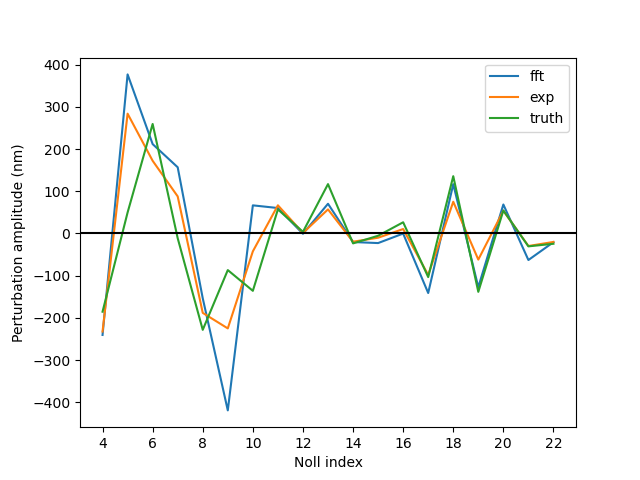

In [16]:
from matplotlib.ticker import MaxNLocator

fft_zk = fftAlgo.getZer4UpInNm()
exp_zk = expAlgo.getZer4UpInNm()
bzk = batoid.zernike(telescope, 0, 0, 622e-9, eps=0.61)*622
for i in range(4, 23):
    print(f"{i:2}  {exp_zk[i-4]:8.3f} nm  {fft_zk[i-4]:8.3f} nm  {bzk[i]:8.3f} nm")

plt.figure()
plt.plot(range(4, 23), fft_zk, label='fft')
plt.plot(range(4, 23), exp_zk, label='exp')
plt.plot(range(4, 23), bzk[4:], label='truth')
plt.legend()
plt.xlabel("Noll index")
plt.ylabel("Perturbation amplitude (nm)")
plt.axhline(0, c='k')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()